In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")

custom_palette = ["black", "red", "green", "orange", "blue"]
sns.set_palette(custom_palette)

calib_method = 'logx_logreg'

# def get_false_discovery_omission(df):

#     discovery_omission = pd.DataFrame(df
#                                       .query('(phase=="test")')
#                                       .filter(['group', 'treat', 'person_id', 'model_id', 'labels', 'fold_id'])
#                                       .assign(f_positive_rate_075 = lambda x: np.where((x.labels==0) & (x.treat>0), 1, 0),
#                                               f_negative_rate_075 = lambda x: np.where((x.labels==1) & (x.treat==0), 1, 0),
#                                               f_positive_rate_20 = lambda x: np.where((x.labels==0) & (x.treat==2), 1, 0),
#                                               f_negative_rate_20 = lambda x: np.where((x.labels==1) & (x.treat<2), 1, 0),
#                                               fraction_treated = lambda x: np.where(x.treat>0, 1, 0),
#                                              )
#                                       .filter(['group', 'model_id', 'fold_id',
#                                                'f_positive_rate_075', 'f_negative_rate_075',
#                                                'f_positive_rate_20', 'f_negative_rate_20',
#                                                'fraction_treated'])
#                                       .groupby(['model_id', 'fold_id','group'])
#                                       .mean()
#                                       .stack()
#                                       .reset_index()
#                                       .rename(columns={'level_3':'metric', 0:'performance'})
#                                      )
#     discovery_omission_all = pd.DataFrame(df
#                                       .query('(phase=="test")')
#                                       .filter(['treat', 'person_id', 'model_id', 'labels', 'fold_id'])
#                                       .assign(f_positive_rate_075 = lambda x: np.where((x.labels==0) & (x.treat>0), 1, 0),
#                                               f_negative_rate_075 = lambda x: np.where((x.labels==1) & (x.treat==0), 1, 0),
#                                               f_positive_rate_20 = lambda x: np.where((x.labels==0) & (x.treat==2), 1, 0),
#                                               f_negative_rate_20 = lambda x: np.where((x.labels==1) & (x.treat<2), 1, 0),
#                                               fraction_treated = lambda x: np.where(x.treat>0, 1, 0),
#                                              )
#                                       .filter(['model_id', 'fold_id',
#                                                'f_positive_rate_075', 'f_negative_rate_075',
#                                                'f_positive_rate_20', 'f_negative_rate_20',
#                                                'fraction_treated'])
#                                       .groupby(['model_id', 'fold_id'])
#                                       .mean()
#                                       .stack()
#                                       .reset_index()
#                                       .rename(columns={'level_2':'metric', 0:'performance'})
#                                     .assign(group='all')
#                                      )
#     return discovery_omission.append(discovery_omission_all)



args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        
        'eval_fold':  'eval',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 
       }

In [3]:
plot_df_all = []
eqodds_threshold=0.1
for experiment in ['original_pce', 'revised_pce', 'apr14_erm', 'apr14_erm_recalib', 'apr14_mmd']:
    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                  experiment, 'performance',
                                  'all')
    preds_path = os.path.join(aggregate_path, 'predictions.csv')

    preds = pd.read_csv(preds_path)
    if 'model_id' not in preds.columns:
        preds = preds.assign(model_id=0)
    if 'fold_id' not in preds.columns:
        preds = preds.assign(fold_id=0)

    #discovery_omission = get_false_discovery_omission(preds)
    df_general = pd.read_csv(os.path.join(aggregate_path, 'standard_evaluation.csv'))
    df_fair = pd.read_csv(os.path.join(aggregate_path, 'fairness_evaluation.csv'))

    thr_calibs = pd.read_csv(os.path.join(aggregate_path, 'calibration', calib_method, 'calibration_sensitivity_thresholds_raw.csv'))
    
    thr_calibs = (thr_calibs
                  .assign(metric = lambda x: 'outcome_rate_' + x.pred_probs.map({0.075: '075', 0.2: '20'}))
                  .rename(columns = {'calibration_density': 'performance'})
                  .filter(df_fair.columns)
                 )

    plot_df = (df_general
               .append(df_fair)
               .append(thr_calibs)
              )

    if experiment in ['apr14_mmd', 'apr14_thr']:
        plot_df = plot_df.query('model_id == @eqodds_threshold')
    
    if 'model_id' not in plot_df.columns:
        plot_df = plot_df.assign(model_id=0)
    if 'fold_id' not in plot_df.columns:
        plot_df = plot_df.assign(fold_id=0)
        

    plot_df = (plot_df
                    .set_index(['model_id','fold_id'], drop=True)
                    .filter(['metric', 'performance_overall', 'performance', 'violation', 'group'])
                    .drop_duplicates()
                    .reset_index()
               #.append(discovery_omission)
               .assign(model_type = experiment)
    )  
    
    plot_df_all.append(plot_df)  
plot_df_all = pd.concat(plot_df_all)
plot_df_all = plot_df_all.assign(model_type = lambda x: x.model_type.map({'original_pce': 'PCE',
                                                                          'revised_pce': 'revPCE',
                             'apr14_erm': 'Base',
                             'apr14_erm_recalib': 'recBase',
                             'apr14_mmd': 'EqOdd'}))

In [4]:
# to_plot1 = (plot_df_all
#            .query("(metric=='auc') | (metric=='auprc') | (metric=='loss_bce')")
#            .assign(metric = lambda x: x.metric.map({'auc': 'AUC', 'auprc': 'AUPRC', 'loss_bce': 'loss'}),
#                   row='A')
#           )
# to_plot2 = (plot_df_all
#            .query("(metric=='emd_0_ova') | (metric=='emd_1_ova') | (metric=='ace_rmse_logistic_log')")
#            .assign(metric = lambda x: x.metric.map({'emd_0_ova': 'EMD (no outcome)',
#                              'emd_1_ova': 'EMD (outcome)', 'ace_rmse_logistic_log': 'ACE'}),
#                   row='B')
#           )

# to_plot = to_plot1.append(to_plot2)
to_plot1 = (plot_df_all
           .query("(metric=='auc') | (metric=='auprc') | (metric=='loss_bce')")
           .assign(metric = lambda x: x.metric.map({'auc': 'AUC', 'auprc': 'AUPRC', 'loss_bce': 'loss'}),
                  row='A',
                  group=lambda x: x.group.astype(str))
          )
to_plot2 = (plot_df_all
           .query("(metric=='emd_0_ova') | (metric=='emd_1_ova') | (metric=='ace_rmse_logistic_log')")
           .assign(metric = lambda x: x.metric.map({'emd_0_ova': 'EMD (no outcome)',
                             'emd_1_ova': 'EMD (outcome)', 'ace_rmse_logistic_log': 'ACE'}),
                  row='B',
                  group=lambda x: x.group.astype(str))
          )

to_plot = to_plot1.append(to_plot2)

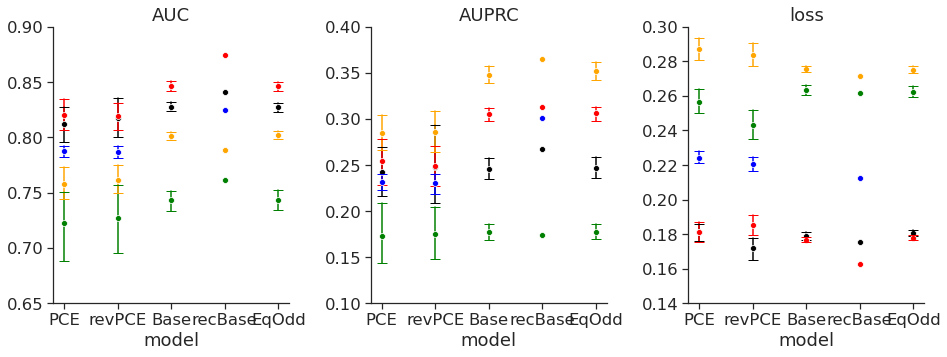

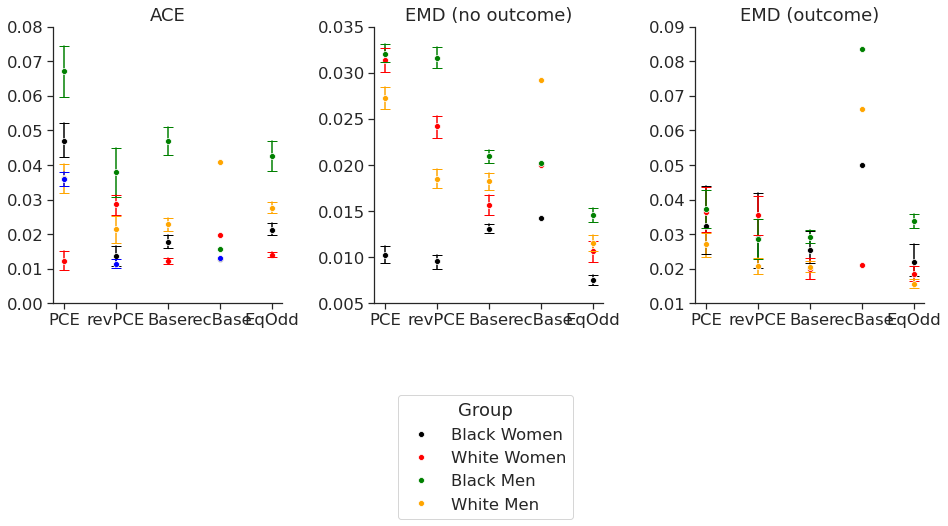

In [5]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

g=sns.relplot(data = to_plot1,
                x = 'model_type',
                y = 'performance',
                col='metric',
                kind = 'line',
                palette = custom_palette, 
                hue='group',
                err_style="bars",
                facet_kws= {'sharey': False, 'margin_titles': True},
                err_kws = {'capsize': 5},
                legend=False,
                aspect=0.9,
                marker='o',
                linestyle='')
(g.set_xlabels('model')
 .set_ylabels('')
 .set_titles(row_template="", col_template="{col_name}")
 .set_yticklabels()
)
h=sns.relplot(data = to_plot2,
                x = 'model_type',
                y = 'performance',
                col='metric',
                kind = 'line',
                palette = custom_palette, 
                hue='group',
                err_style="bars",
                facet_kws= {'sharey': False, 'margin_titles': True},
                err_kws = {'capsize': 5},
                legend=False,
                aspect=0.9,
                marker='o',
                linestyle='')

(h.set_xlabels('')
 .set_ylabels('')
 .set_titles(row_template="", col_template="{col_name}")
 .set_yticklabels()
)

plt.legend(title='Group', labels=['Black Women', 'White Women', 'Black Men', 'White Men'],
           bbox_to_anchor=(-0.5,-.3)) #bbox_to_anchor=(1, 1))
#plt.savefig("seaborn_combine_two_plots_with_shared_x_axis_Python.png")
sns.set(font_scale=1)

In [6]:
df_threshold_1 = (plot_df_all.query(
#     '(metric=="f_positive_rate_075") | \
#                                      (metric=="f_negative_rate_075") | \
#                                      (metric=="outcome_rate_075")'
      '(metric=="specificity_0.075") |(metric=="recall_0.075") | (metric=="outcome_rate_075")'
)
                
                                     
                  .assign(threshold='7.5%')
                 )
df_threshold_2 = (plot_df_all.query(
    '(metric=="specificity_0.2") | (metric=="recall_0.2") |(metric=="outcome_rate_20")'
#     '(metric=="f_positive_rate_20") | \
#                                     (metric=="f_negative_rate_20")| \
#                                      (metric=="outcome_rate_20")'
)
#
                  .assign(threshold='20%')


                 )


df_thresholds = (df_threshold_1.append(df_threshold_2)
                  .assign(metric=lambda x: x.metric.map({'specificity_0.2': 'specificity',
                                                         'recall_0.2': 'sensitivity',
                                                         'f_positive_rate_20': 'FPR',
                                                         'f_negative_rate_20': 'FNR',
                                                         'specificity_0.075': 'specificity',
                                                         'recall_0.075': 'sensitivity',
                                                         'f_positive_rate_075': 'FPR',
                                                         'f_negative_rate_075': 'FNR',
                                                        'outcome_rate_075': 'outcome rate',
                                                        'outcome_rate_20': 'outcome rate'})
                ))

In [7]:
df_thresholds.query("model_type=='recBase'").groupby([
    'metric', 'group', 'threshold'
]).count()

model_id  fold_id  performance  model_type  \
metric       group threshold                                               
outcome rate 1     20%            1000     1000         1000        1000   
                   7.5%           1000     1000         1000        1000   
             2     20%            1000     1000         1000        1000   
                   7.5%           1000     1000         1000        1000   
             3     20%            1000     1000         1000        1000   
                   7.5%           1000     1000         1000        1000   
             4     20%            1000     1000         1000        1000   
                   7.5%           1000     1000         1000        1000   
             all   20%            1000     1000         1000        1000   
                   7.5%           1000     1000         1000        1000   

                              performance_overall  
metric       group threshold                       
outcome rate 1     20%                          0  
                   7.5%                         0  
             2     20%                          0  
                   7.5%                         0  
             3     20%                          0  
                   7.5%                         0  
             4     20%                          0  
                   7.5%                         0  
             all   20%                          0  
                   7.5%                         0

In [8]:
df["column1"].replace({"a": "x", "b": "y"}, inplace=True)

NameError: name 'df' is not defined

In [ ]:
df_thresholds.group.replace({'all': 'overall'}, inplace=True)

In [9]:
plot_args = {'x': 'model_type', 
            'y': 'performance',
            'col': 'metric',
            'kind': 'line',
            #'palette': custom_palette,
            'hue': 'group',
            'linestyle':'',
            'err_style': 'bars',
            'facet_kws': {'sharey': False, 'margin_titles': True},
            'err_kws': {'capsize': 5},
            'legend': False,
            'marker':'o',
            'aspect':1}

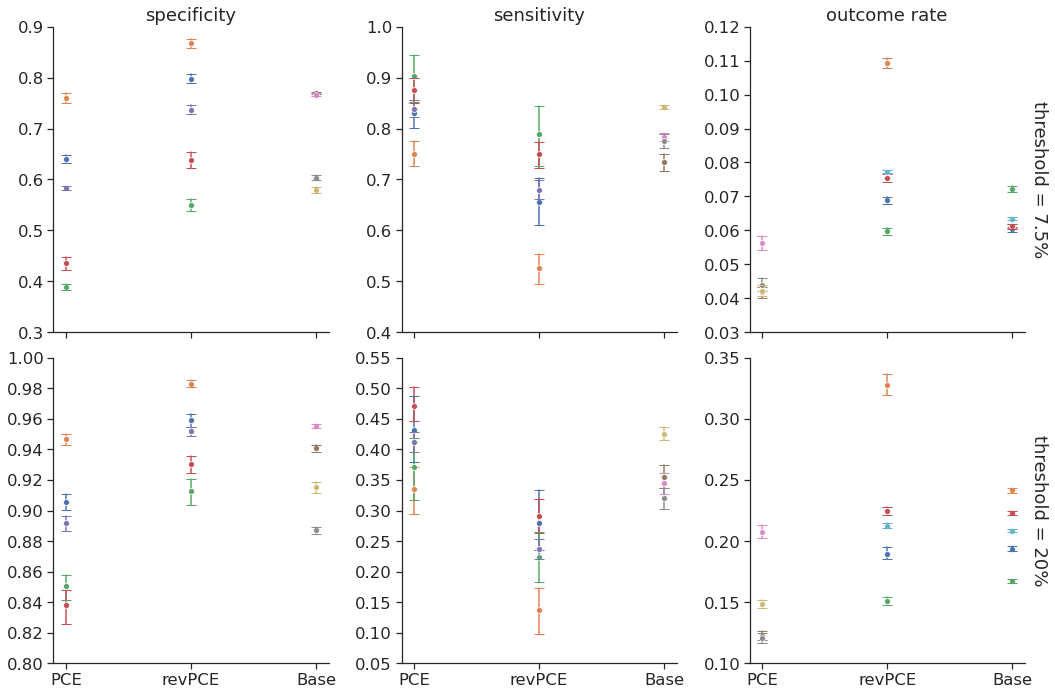

In [10]:
# output_path = os.path.join(args['plot_path'], 
#                            '_'.join(('appendix', model_type, 'threshold_metrics.png')
#                                    )
#                           )


sns.set(font_scale=1.5)
sns.set_style("ticks")

g = sns.relplot(data = df_thresholds.query("model_type!=['EqOdd', 'recBase']"),
                **plot_args,
                row = 'threshold',

               )
#g.set(xscale="log")
(g.set_xlabels('')
 .set_ylabels('')
 .set_yticklabels()
 .set_titles( col_template="{col_name}")
)

axes = g.axes.flatten()
# axes[0].axhline(0.075, ls='--', linewidth=3, color='grey')
# axes[3].axhline(0.2, ls='--', linewidth=3, color='grey')

# axes[0].set_title("outcome rate at t=7.5%")
# axes[1].set_title("FPR at t=7.5%")
# axes[2].set_title("FNR at t=7.5%")
# axes[3].set_title("outcome rate at t=20%")
# axes[4].set_title("FPR at t=20%")
# axes[5].set_title("FNR at t=20%")

# plt.legend(title='Group', labels=['all','Black Women', 'White Women', 'Black Men', 'White Men'],
#            bbox_to_anchor=(-0.5,-.3)) 

sns.set(font_scale=1)

# if save_plots:
#     g.savefig(output_path)